In [1]:
import os
import glob
import wave
import core as co
import pydub
import librosa
import numpy as np
import contextlib
import tensorflow as tf

In [2]:
paths = ['BD15C', 'BD15L', 'BD6B', 'BD6A']

In [3]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)


def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41, label = 1):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.logamplitude(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(l)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels)

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(1.0, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x,W,strides=[1,2,2,1], padding='SAME')

def apply_convolution(x,kernel_size,num_channels,depth):
    weights = weight_variable([kernel_size, kernel_size, num_channels, depth])
    biases = bias_variable([depth])
    return tf.nn.relu(tf.add(conv2d(x, weights),biases))

def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, kernel_size, kernel_size, 1], 
                          strides=[1, stride_size, stride_size, 1], padding='SAME')
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [5]:
parent_dir = '.'
features,labels = extract_features(parent_dir,paths,frames=44)

In [6]:
labels = one_hot_encode(labels)

In [7]:
rnd_indices = np.random.rand(len(labels)) < 0.70

train_x = features[rnd_indices]
train_y = labels[rnd_indices]
test_x = features[~rnd_indices]
test_y = labels[~rnd_indices]

In [8]:
frames = 44
bands = 60

feature_size = bands * frames #60x44
num_labels = 4
num_channels = 2

batch_size = 50
kernel_size = 30
depth = 20
num_hidden = 200

learning_rate = 1e-4
training_iterations = 2000

In [9]:
X = tf.placeholder(tf.float32, shape=[None, bands, frames, num_channels])
Y = tf.placeholder(tf.float32, shape=[None, num_labels])

cov = apply_convolution(X,kernel_size,num_channels,depth)

shape = cov.get_shape().as_list()
cov_flat = tf.reshape(cov, [-1, shape[1] * shape[2] * shape[3]])

f_weights = weight_variable([shape[1] * shape[2] * depth, num_hidden])
f_biases = bias_variable([num_hidden])
f = tf.nn.sigmoid(tf.add(tf.matmul(cov_flat, f_weights),f_biases))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [10]:
cross_entropy = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
cost_history = np.empty(shape=[1],dtype=float)
with tf.Session() as session:
    tf.initialize_all_variables().run()

    for itr in range(training_iterations):    
        offset = (itr * batch_size) % (train_y.shape[0] - batch_size)
        batch_x = train_x[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size), :]
        
        _, c = session.run([optimizer, cross_entropy],feed_dict={X: batch_x, Y : batch_y})
        cost_history = np.append(cost_history,c)
        if itr % 50 == 0:
            print ('Train cost: ',c)
        
    print('Test accuracy: ',round(session.run(accuracy, feed_dict={X: test_x, Y: test_y}) , 3))
    

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Train cost: ', 122.64804)
('Train cost: ', 96.987755)
('Train cost: ', 72.328987)
('Train cost: ', 50.352951)
('Train cost: ', 51.24345)
('Train cost: ', 42.822624)
('Train cost: ', 38.138699)
('Train cost: ', 39.309555)
('Train cost: ', 32.315598)
('Train cost: ', 28.970251)
('Train cost: ', 164.58109)
('Train cost: ', 164.27338)
('Train cost: ', 159.116)
('Train cost: ', 125.27075)
('Train cost: ', 101.48071)
('Train cost: ', 98.843086)
('Train cost: ', 97.657516)
('Train cost: ', 88.418137)
('Train cost: ', 57.518894)
('Train cost: ', 49.645107)
('Train cost: ', 30.823082)
('Train cost: ', 34.885513)
('Train cost: ', 33.228909)
('Train cost: ', 30.450212)
('Train cost: ', 31.419363)
('Train cost: ', 31.182692)
('Train cost: ', 27.437943)
('Train cost: ', 115.06122)
('Train cost: ', 121.64413)
('Train cost: ', 117.50207)
('Train cost: ', 90.488464)
('Train cost: ', 83.631317)
('Train cost: ', 80.647003)
('Tra

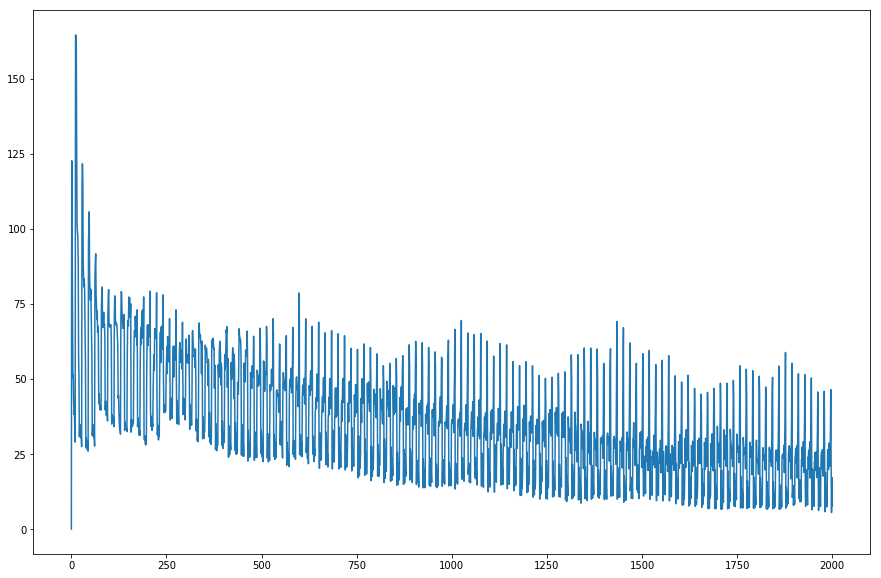

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.plot(cost_history)
# plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

In [13]:
cost_history

array([  4.94065646e-324,   1.22648041e+002,   9.69877548e+001, ...,
         5.53606844e+000,   1.71908627e+001,   7.76005697e+000])